In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer
import gym_Aircraft

from itertools import count
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
env_id = "acav-v0"
env = gym.make(env_id)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [5]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(1000)

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [7]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [8]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [9]:
num_episodes = 1000
batch_size = 32
gamma=0.99
TARGET_UPDATE=10
hcmd_coef=0.0005

losses = []
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset(hcmd_coef)

    for t in count():
        # 행동 선택과 수행
        
        action = current_model.act(state)
        
        next_state, reward, done, res = env.step(action)
        
        # 메모리에 변이 저장
        replay_buffer.push(state, action, reward, next_state, done)
        

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        

        # 다음 상태로 이동
        state = next_state

     
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward))
            break
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        update_target(current_model, target_model)

print('Complete')
env.close()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


2020/10/06 16:48:43
episode : 0 | final step : 98 | total reward : -108.15
2020/10/06 16:48:45
episode : 1 | final step : 98 | total reward : -121.275
2020/10/06 16:48:46
episode : 2 | final step : 99 | total reward : -23.75
2020/10/06 16:48:47
episode : 3 | final step : 98 | total reward : -121.275
2020/10/06 16:48:48
episode : 4 | final step : 98 | total reward : -121.275
2020/10/06 16:48:49
episode : 5 | final step : 99 | total reward : -23.75
2020/10/06 16:48:50
episode : 6 | final step : 98 | total reward : -121.275
2020/10/06 16:48:51
episode : 7 | final step : 98 | total reward : -21.275000000000006
2020/10/06 16:48:52
episode : 8 | final step : 100 | total reward : -26.25
2020/10/06 16:48:53
episode : 9 | final step : 99 | total reward : -123.75
2020/10/06 16:48:54
episode : 10 | final step : 98 | total reward : -121.275
2020/10/06 16:48:56
episode : 11 | final step : 99 | total reward : -123.75
2020/10/06 16:48:57
episode : 12 | final step : 98 | total reward : -121.275
2020/1

2020/10/06 16:52:36
episode : 105 | final step : 99 | total reward : -23.75
2020/10/06 16:52:40
episode : 106 | final step : 98 | total reward : -121.275
2020/10/06 16:52:43
episode : 107 | final step : 98 | total reward : -121.275
2020/10/06 16:52:46
episode : 108 | final step : 98 | total reward : -121.275
2020/10/06 16:52:49
episode : 109 | final step : 98 | total reward : -121.275
2020/10/06 16:52:53
episode : 110 | final step : 98 | total reward : -121.275
2020/10/06 16:52:56
episode : 111 | final step : 98 | total reward : -121.275
2020/10/06 16:52:59
episode : 112 | final step : 96 | total reward : -16.400000000000006
2020/10/06 16:53:03
episode : 113 | final step : 98 | total reward : -121.275
2020/10/06 16:53:06
episode : 114 | final step : 98 | total reward : -121.275
2020/10/06 16:53:09
episode : 115 | final step : 99 | total reward : -123.75
2020/10/06 16:53:12
episode : 116 | final step : 99 | total reward : -123.75
2020/10/06 16:53:16
episode : 117 | final step : 98 | tot

2020/10/06 16:58:21
episode : 209 | final step : 98 | total reward : -121.275
2020/10/06 16:58:24
episode : 210 | final step : 99 | total reward : -23.75
2020/10/06 16:58:27
episode : 211 | final step : 97 | total reward : -18.825000000000003
2020/10/06 16:58:30
episode : 212 | final step : 98 | total reward : -121.275
2020/10/06 16:58:34
episode : 213 | final step : 99 | total reward : -123.75
2020/10/06 16:58:37
episode : 214 | final step : 98 | total reward : -121.275
2020/10/06 16:58:40
episode : 215 | final step : 102 | total reward : -31.325000000000017
2020/10/06 16:58:44
episode : 216 | final step : 99 | total reward : -123.75
2020/10/06 16:58:48
episode : 217 | final step : 98 | total reward : -21.275000000000006
2020/10/06 16:58:51
episode : 218 | final step : 98 | total reward : -121.275
2020/10/06 16:58:54
episode : 219 | final step : 99 | total reward : -123.75
2020/10/06 16:58:58
episode : 220 | final step : 98 | total reward : -121.275
2020/10/06 16:59:01
episode : 221 |

2020/10/06 17:04:08
episode : 312 | final step : 99 | total reward : -123.75
2020/10/06 17:04:11
episode : 313 | final step : 100 | total reward : -26.25
2020/10/06 17:04:14
episode : 314 | final step : 100 | total reward : -126.25
2020/10/06 17:04:18
episode : 315 | final step : 98 | total reward : -121.275
2020/10/06 17:04:21
episode : 316 | final step : 100 | total reward : -126.25
2020/10/06 17:04:24
episode : 317 | final step : 98 | total reward : -121.275
2020/10/06 17:04:27
episode : 318 | final step : 98 | total reward : -121.275
2020/10/06 17:04:31
episode : 319 | final step : 99 | total reward : -123.75
2020/10/06 17:04:34
episode : 320 | final step : 98 | total reward : -121.275
2020/10/06 17:04:38
episode : 321 | final step : 98 | total reward : -121.275
2020/10/06 17:04:41
episode : 322 | final step : 98 | total reward : -121.275
2020/10/06 17:04:44
episode : 323 | final step : 100 | total reward : -26.25
2020/10/06 17:04:47
episode : 324 | final step : 98 | total reward :

2020/10/06 17:09:52
episode : 415 | final step : 100 | total reward : -26.25
2020/10/06 17:09:55
episode : 416 | final step : 100 | total reward : -26.25
2020/10/06 17:09:58
episode : 417 | final step : 100 | total reward : -26.25
2020/10/06 17:10:01
episode : 418 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:10:05
episode : 419 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:10:09
episode : 420 | final step : 99 | total reward : -23.75
2020/10/06 17:10:12
episode : 421 | final step : 100 | total reward : -26.25
2020/10/06 17:10:14
episode : 422 | final step : 99 | total reward : -23.75
2020/10/06 17:10:18
episode : 423 | final step : 100 | total reward : -26.25
2020/10/06 17:10:21
episode : 424 | final step : 97 | total reward : -18.825000000000003
2020/10/06 17:10:25
episode : 425 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:10:27
episode : 426 | final step : 96 | total reward : -16.400000000000006
2020/10/06 17:10:3

2020/10/06 17:15:38
episode : 518 | final step : 99 | total reward : -23.75
2020/10/06 17:15:41
episode : 519 | final step : 100 | total reward : -26.25
2020/10/06 17:15:44
episode : 520 | final step : 100 | total reward : -26.25
2020/10/06 17:15:48
episode : 521 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:15:51
episode : 522 | final step : 99 | total reward : -23.75
2020/10/06 17:15:54
episode : 523 | final step : 99 | total reward : -23.75
2020/10/06 17:15:57
episode : 524 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:16:01
episode : 525 | final step : 93 | total reward : -9.275000000000006
2020/10/06 17:16:04
episode : 526 | final step : 99 | total reward : -23.75
2020/10/06 17:16:07
episode : 527 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:16:11
episode : 528 | final step : 99 | total reward : -23.75
2020/10/06 17:16:14
episode : 529 | final step : 97 | total reward : -18.825000000000003
2020/10/06 17:16:17
ep

2020/10/06 17:21:20
episode : 620 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:21:23
episode : 621 | final step : 99 | total reward : -23.75
2020/10/06 17:21:27
episode : 622 | final step : 97 | total reward : -18.825000000000003
2020/10/06 17:21:30
episode : 623 | final step : 95 | total reward : -14.0
2020/10/06 17:21:34
episode : 624 | final step : 99 | total reward : -23.75
2020/10/06 17:21:37
episode : 625 | final step : 100 | total reward : -26.25
2020/10/06 17:21:41
episode : 626 | final step : 99 | total reward : -23.75
2020/10/06 17:21:44
episode : 627 | final step : 100 | total reward : -26.25
2020/10/06 17:21:47
episode : 628 | final step : 100 | total reward : -26.25
2020/10/06 17:21:51
episode : 629 | final step : 100 | total reward : -26.25
2020/10/06 17:21:55
episode : 630 | final step : 100 | total reward : -26.25
2020/10/06 17:21:58
episode : 631 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:22:01
episode : 632 | final ste

2020/10/06 17:27:06
episode : 723 | final step : 100 | total reward : -26.25
2020/10/06 17:27:09
episode : 724 | final step : 93 | total reward : -9.275000000000006
2020/10/06 17:27:13
episode : 725 | final step : 100 | total reward : -26.25
2020/10/06 17:27:16
episode : 726 | final step : 100 | total reward : -26.25
2020/10/06 17:27:20
episode : 727 | final step : 99 | total reward : -19.549999999999983
2020/10/06 17:27:23
episode : 728 | final step : 100 | total reward : -26.25
2020/10/06 17:27:26
episode : 729 | final step : 100 | total reward : -26.25
2020/10/06 17:27:30
episode : 730 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:27:34
episode : 731 | final step : 100 | total reward : -26.25
2020/10/06 17:27:37
episode : 732 | final step : 100 | total reward : -26.25
2020/10/06 17:27:40
episode : 733 | final step : 97 | total reward : -18.825000000000003
2020/10/06 17:27:44
episode : 734 | final step : 100 | total reward : -26.25
2020/10/06 17:27:47
episode :

2020/10/06 17:32:47
episode : 825 | final step : 99 | total reward : -23.75
2020/10/06 17:32:51
episode : 826 | final step : 98 | total reward : -21.275000000000006
2020/10/06 17:32:54
episode : 827 | final step : 93 | total reward : -7.700000000000003
2020/10/06 17:32:57
episode : 828 | final step : 100 | total reward : -26.25
2020/10/06 17:33:00
episode : 829 | final step : 99 | total reward : -23.75
2020/10/06 17:33:03
episode : 830 | final step : 100 | total reward : -26.25
2020/10/06 17:33:06
episode : 831 | final step : 97 | total reward : -18.825000000000003
2020/10/06 17:33:09
episode : 832 | final step : 99 | total reward : -23.75
2020/10/06 17:33:12
episode : 833 | final step : 100 | total reward : -26.25
2020/10/06 17:33:15
episode : 834 | final step : 100 | total reward : -26.25
2020/10/06 17:33:19
episode : 835 | final step : 99 | total reward : -23.75
2020/10/06 17:33:22
episode : 836 | final step : 100 | total reward : -26.25
2020/10/06 17:33:25
episode : 837 | final ste

2020/10/06 17:38:29
episode : 928 | final step : 100 | total reward : -26.25
2020/10/06 17:38:33
episode : 929 | final step : 94 | total reward : -11.625
2020/10/06 17:38:36
episode : 930 | final step : 94 | total reward : -11.625
2020/10/06 17:38:39
episode : 931 | final step : 100 | total reward : -26.25
2020/10/06 17:38:42
episode : 932 | final step : 99 | total reward : -23.75
2020/10/06 17:38:46
episode : 933 | final step : 93 | total reward : -9.275000000000006
2020/10/06 17:38:49
episode : 934 | final step : 99 | total reward : -23.75
2020/10/06 17:38:52
episode : 935 | final step : 96 | total reward : -16.400000000000006
2020/10/06 17:38:56
episode : 936 | final step : 99 | total reward : -23.75
2020/10/06 17:38:59
episode : 937 | final step : 100 | total reward : -26.25
2020/10/06 17:39:02
episode : 938 | final step : 99 | total reward : -23.75
2020/10/06 17:39:06
episode : 939 | final step : 97 | total reward : -18.825000000000003
2020/10/06 17:39:09
episode : 940 | final ste

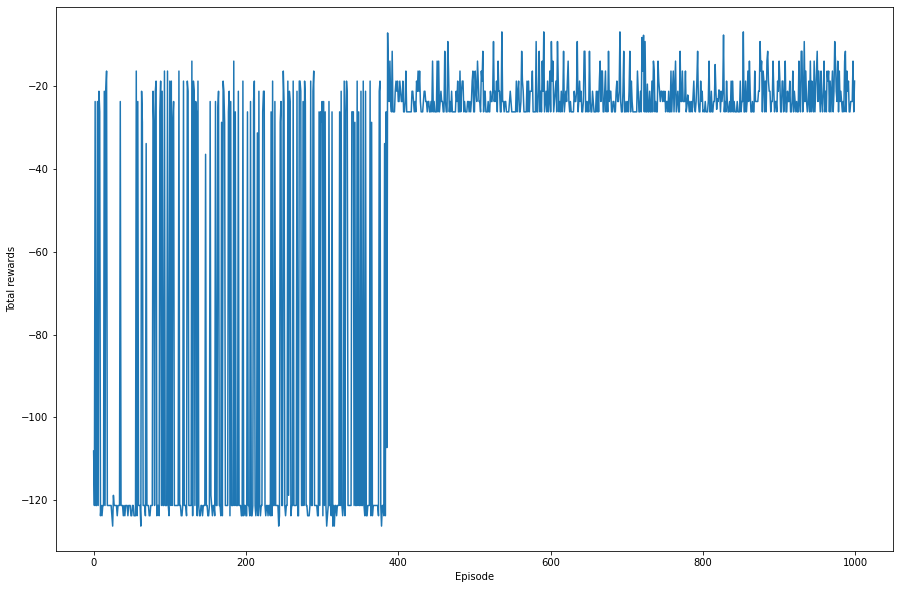

In [10]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

In [11]:
def moving_average(data,n):
    len_data=len(data)-n
    res_data=np.zeros(len_data)

    for i in range(len_data):
        res_data[i]=sum(data[i:i+n])/n
    return res_data

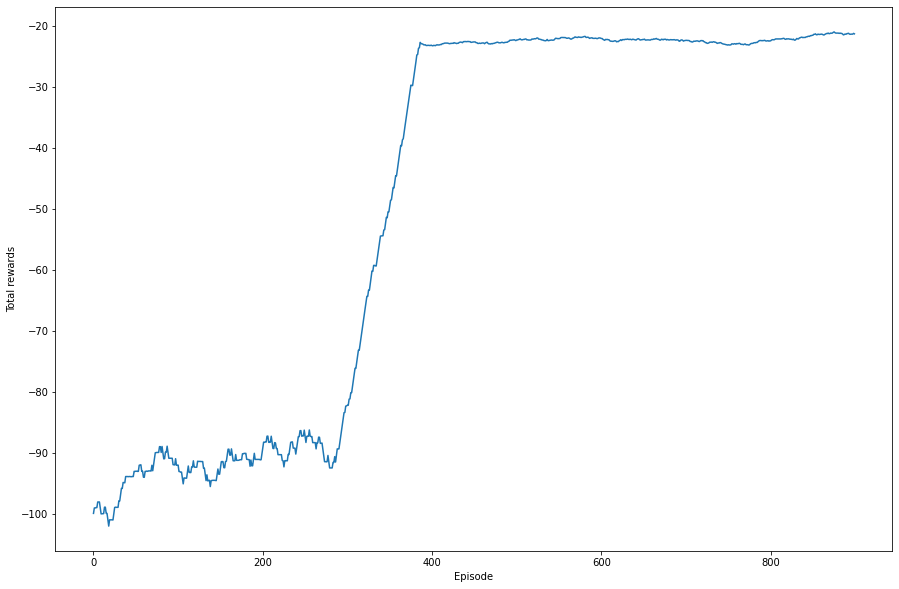

In [12]:
average_number=100
filtered_data=moving_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

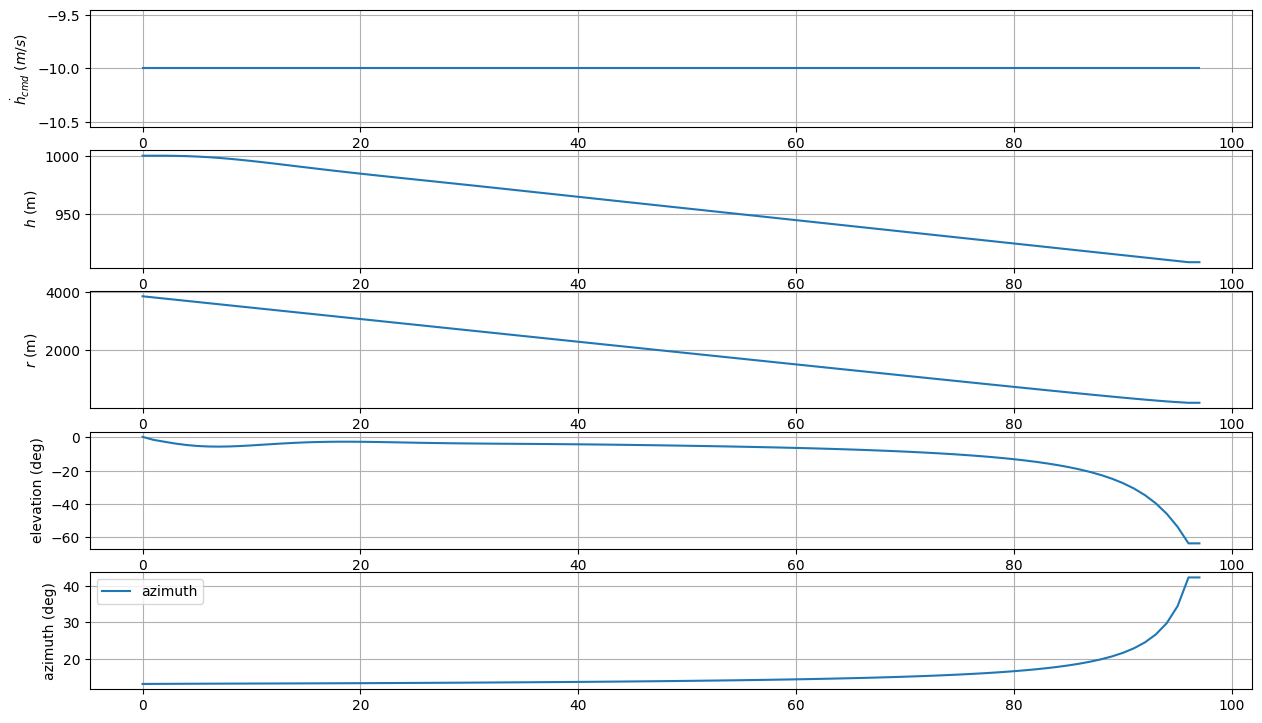

In [13]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[999]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

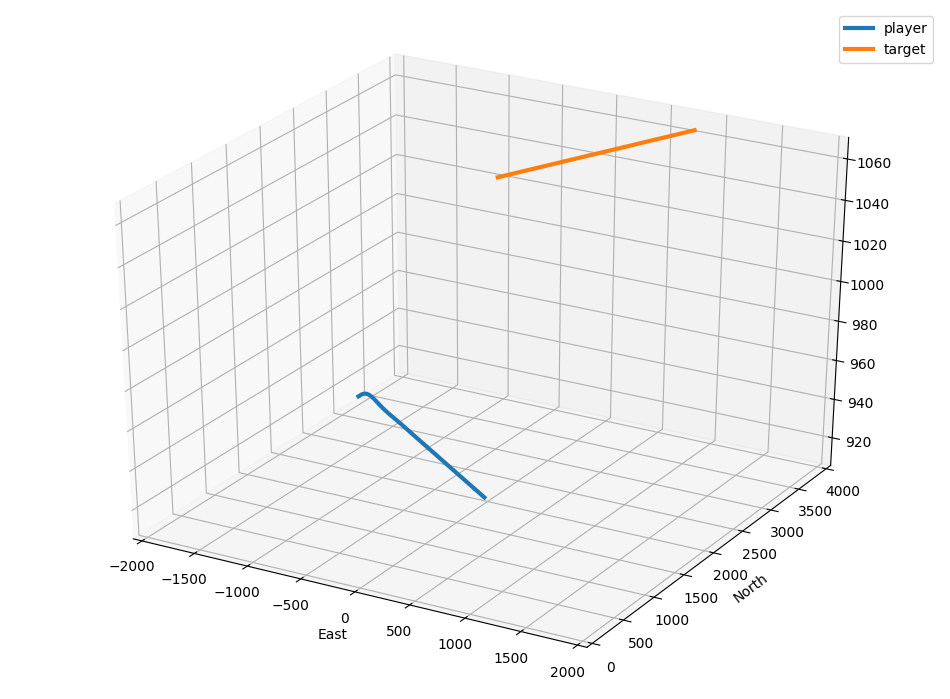

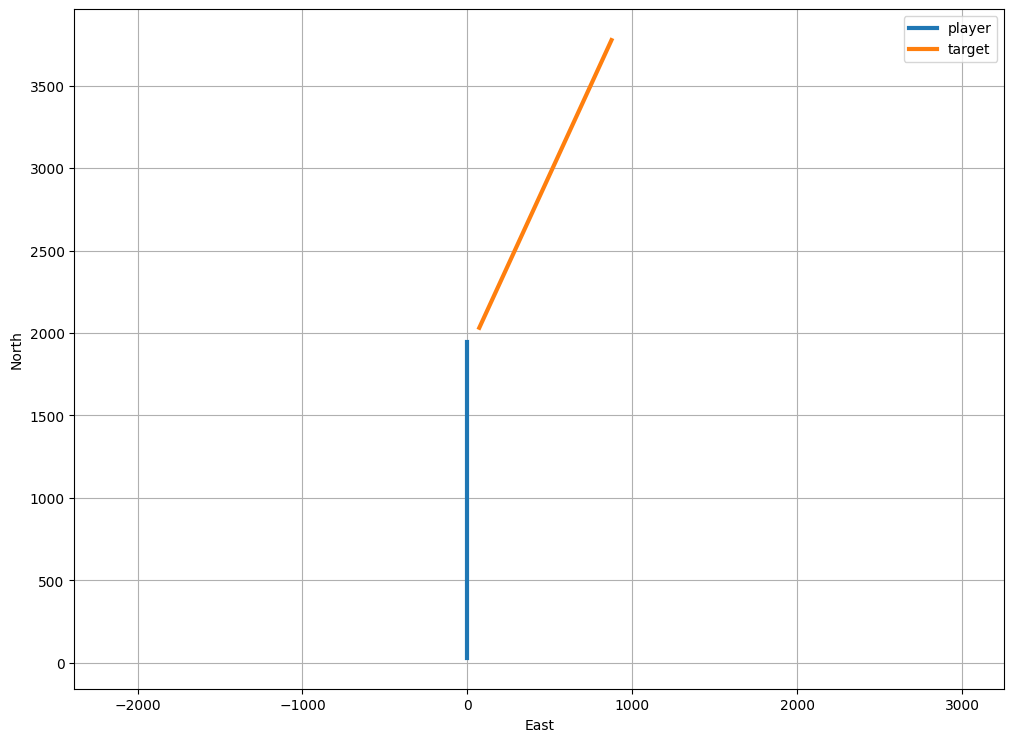

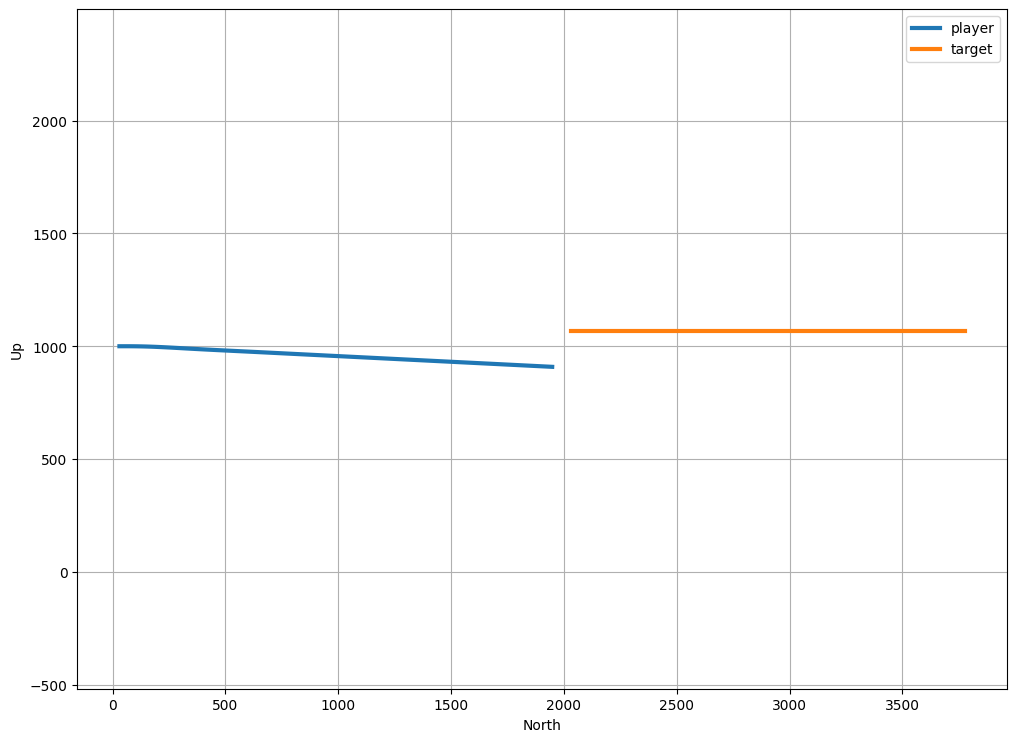

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()